<h1 align="center"><font face="Times New Roman">Negative Binomial Regression Model</font> </h1>

<font face="Times New Roman">
<h2>1. Load the Libraries</h2>
Load the libraries for the execusion of the program. Incase of an error, use the below installation procedure</font>
<pre><code>
    # Install a pip package in the current Jupyter kernel
    import sys
    !{sys.executable} -m pip install *package_name*
</code></pre>

In [1]:
### Load the libraries
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

<font face="Times New Roman"><h2>2. Import Data</h2>
Set the path variable to where the github code folder is cloned to access the data</font>

In [2]:
## Importing Dataset
path = 'C:/Users/DELL/OneDrive/Documents/project/Updated Code and Datasets/'
df = pd.read_csv(path + 'model_data.csv')

<font face="Times New Roman"><h2>3. Data Cleaning and pre-processing</h2></font>
<font face="Times New Roman"><h3>3.1 Obtaining Required Variables</h3></font>

In [3]:
# Considering Data Only from Games >= 7
# Using Past 6 Games for Information
data = df.dropna(subset=['RefGSF'])

## Filter Dataset with Required Variables Only 
imp_var = [0, 1, 9]
imp_var.extend(list(range(34, 48)))

data = data.iloc[:,imp_var]

<font face="Times New Roman"><h3>3.2. Variable Transformation</h3></font>

In [4]:
## Transformations

# Change Values from 0 to 0.1 for Log-Transformation
data['GoalsScored'] = np.where(data['GoalsScored'] != 0, data['GoalsScored'], 0.1) 
data['RefGSF'] = np.where(data['RefGSF']  != 0, data['RefGSF'], 0.1)
data['OppGDF'] = np.where(data['OppGDF'] != 0, data['OppGDF'], 0.1)

# Log Transformation
log_var = [2]
log_var.extend(list(range(8, 15)))
data.iloc[:, log_var] = np.log(data.iloc[:, log_var])

<font face="Times New Roman"><h3>3.3. Train-Test-Validation Split</h3></font>

In [5]:
## Training-Validation-Test Data Split
data_train = data[data['Season'].isin([20172018,20182019,20192020])]
data_valid = data[data['Season'] == 20202021]
data_test = data[data['Season'] == 20212022]

data_train = data_train.drop(columns = ['Season'])
data_valid= data_valid.drop(columns = ['Season'])
data_test = data_test.drop(columns = ['Season'])

<font face="Times New Roman"><h2>4. Exploratory Data Analysis</h2></font>

<AxesSubplot:>

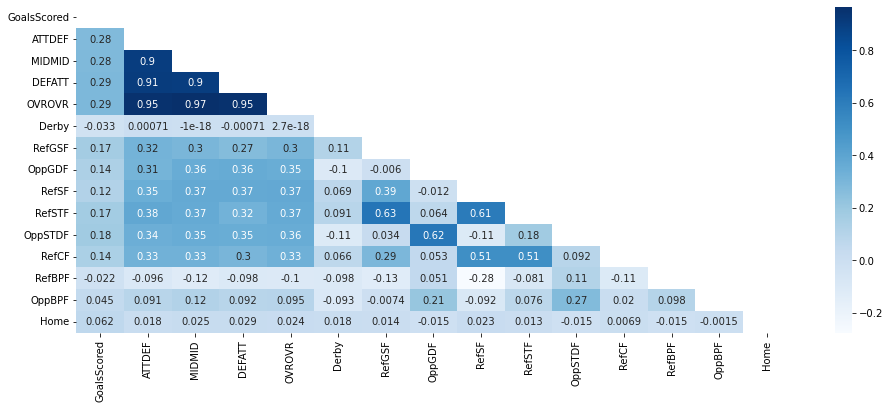

In [6]:
## Analysis of Variable Relationships

corr = data_train.drop(columns = ['Index']).corr()

# Getting the Upper Triangle of the Correlation Matrix
matrix = np.triu(corr)

# Plotting a Correlation Heatmap
plt.figure(figsize=(16, 6))
sns.heatmap(corr, annot=True, mask=matrix, annot_kws={"size": 10}, cmap="Blues")

<font face="Times New Roman"><h2>5. The Poisson Linear Model</h2></font>
<font face="Times New Roman"><h3>5.1 Fit the model</h3></font>

In [7]:
## Regression Input and Output Variables
Y = data_train['GoalsScored']
X = data_train[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X = sm.add_constant(X)

### Modelling

## Linear Regression (OLS)
reg = sm.OLS(Y, X)
fit = reg.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoalsScored   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     42.50
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           1.24e-41
Time:                        20:18:15   Log-Likelihood:                -3129.5
No. Observations:                1924   AIC:                             6271.
Df Residuals:                    1918   BIC:                             6304.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4513      0.249     -5.827      0.000      -1.940      -0.963
Home           0.1485      0.056      2.637      0.008       0.038       0.259
Derby         -0.1668      0.114     -1.460      0.144      -0.391       0.057
OVROVR         0.0552      0.006      9.507      0.000       0.044       0.067
RefSTF         0.2974      0.090      3.294      0.001       0.120       0.475
OppSTDF        0.3181      0.097      3.275      0.001       0.128       0.509
==============================================================================
Omnibus:                      265.210   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              212.074
Skew:                          -0.721   Prob(JB):                     8.89e-47
Kurtosis:                       2.246   Cond. No.                         51.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
## Fit Model on Validation Data
X_valid = data_valid[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X_valid = sm.add_constant(X_valid)

## Fit Lambda Values on Test Data
data = df.dropna(subset=['RefGSF'])
data_valid = data[data['Season'] == 20202021]
data_valid['Exp'] = np.exp(fit.predict(X_valid))

C:\Users\DELL\AppData\Local\Temp\ipykernel_6956\3778819060.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_valid['Exp'] = np.exp(fit.predict(X_valid))


<font face="Times New Roman"><h3>5.2 Optimising <i>'p'</i> parameter with RPS value</h3>
</font>

In [9]:
## Ranked Probability Score (RPS)
RPS_model = []
RPS_bookies = []

# RPS Function
def rps(predictions, observed):

    assert (
        predictions.shape == observed.shape
    ), "prediction and observed array shapes must match"
    ncat = predictions.shape[1] - 1
    return (
        np.sum(
            (np.cumsum(predictions, axis=1) - np.cumsum(observed, axis=1)) ** 2, axis=1
        ) / ncat
    )

<p>&#10071;&#9203; The following code block takes a little more than 3 minutes to run</p>

In [10]:
### Optimising for the p Parameter in Negative Binomial

## Formula : Mean=pr/1-p
p = np.linspace(0.25,0.75, 51)
RPS_Diff = []
for i in p:
    # Scoreline simulation
    sim = []
    for j in range(len(data_valid.index)):
        val = list(np.random.negative_binomial(data_valid.iloc[j]['Exp'] * (1-i)/i, i, 10000))
        sim.append(val)
        #print(j)

    sim_df = pd.DataFrame(sim)

    sim_df['Index'] = list(data_valid['Index'])
    sim_df['Home'] = list(data_valid['Home'])

    index_set = list(set(sim_df['Index']))
    sim_prob = []
    for j in index_set:
        df_temp = sim_df[sim_df['Index'] == j]
        
        home = df_temp[df_temp['Home'] == 1]
        home = home.drop(columns = ['Index','Home'])
        away = df_temp[df_temp['Home'] == 0]
        away = away.drop(columns = ['Index','Home'])
        
        goal_diff = np.array(home) - np.array(away)
        home_win = len(goal_diff[goal_diff > 0])/10000
        draw = len(goal_diff[goal_diff == 0])/10000
        home_loss = len(goal_diff[goal_diff < 0])/10000
        prob = [home_win, draw, home_loss]
        sim_prob.append(prob)
    
    sim_prob_df = pd.DataFrame(sim_prob, 
                               columns = ['HomeWin', 'Draw', 'HomeLoss'])
    sim_prob_df['Index'] = index_set          
            
    # Comparison with Bet365 and Reality
    df_betting = pd.read_csv(path + 'betting_data.csv')            
    data_betting = df_betting[df_betting['Season'] == 20202021]
    data_betting = pd.merge(data_betting, sim_prob_df, on = 'Index')
    
    bookies_prob = []
    for j in range(len(data_betting)):
        Sum = 1/data_betting['B365H'][j] + 1/data_betting['B365D'][j] + 1/data_betting['B365A'][j]
        Bet365HomeWin = (1/data_betting['B365H'][j])/Sum
        Bet365Draw = (1/data_betting['B365D'][j])/Sum
        Bet365AwayWin = (1/data_betting['B365A'][j])/Sum
        IN = data_betting['Index'][j]
        prob = [Bet365HomeWin, Bet365Draw, Bet365AwayWin, IN]
        bookies_prob.append(prob)

    bookies_prob_df = pd.DataFrame(bookies_prob, columns = ['BookiesWin', 'BookiesDraw', 'BookiesLoss', 'Index'])
      
    data_betting = pd.merge(data_betting, bookies_prob_df, on = 'Index')


    predictions_model = data_betting[['HomeWin', 'Draw', 'HomeLoss']]
    predictions_model.columns = ['H', 'D', 'A']
    predictions_bookies = data_betting[['BookiesWin', 'BookiesDraw', 'BookiesLoss']]
    predictions_bookies.columns = ['H', 'D', 'A']
    observed = pd.get_dummies(data_betting['FTR']).reindex(
        columns=predictions_model.columns, fill_value=0)
    RPS_model = rps(predictions_model, observed).round(5)
    RPS_bookies= rps(predictions_bookies, observed).round(5)

    diff = np.mean(RPS_model) - np.mean(RPS_bookies)
    #print(i)
    RPS_Diff.append(diff)

## Find Optimal p
df_p = pd.DataFrame(RPS_Diff, columns = ['RPS'])
df_p['p'] = p

## p at Minimum RPS Difference (0.0066)
df_p_min = df_p[df_p['RPS'] == min(df_p['RPS'])]
p = df_p_min.iloc[0,1]
print("Optimal 'p' value",p)

Optimal 'p' value 0.42000000000000004


<font face="Times New Roman"><h3>5.3 Model Fit with Optimal <i>p</i> value</h3>
</font>

In [11]:
### Model with Optimal 'p' Value 

## Include First 4 Season in Training Data
data_train = data[data['Season'].isin([20172018,20182019,20192020,20202021])]
data_train = data_train.drop(columns = ['Season'])

## Regression Input and Output Variables
Y = data_train['GoalsScored']
X = data_train[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X = sm.add_constant(X)

## Linear Regression (OLS)
reg = sm.OLS(Y, X)
fit = reg.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            GoalsScored   R-squared:                       0.127
Model:                            OLS   Adj. R-squared:                  0.126
Method:                 Least Squares   F-statistic:                     74.76
Date:                Fri, 29 Jul 2022   Prob (F-statistic):           2.71e-73
Time:                        20:20:54   Log-Likelihood:                -3998.9
No. Observations:                2566   AIC:                             8010.
Df Residuals:                    2560   BIC:                             8045.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7227      0.123      5.895      0.000       0.482       0.963
Home           0.1975      0.046      4.341      0.000       0.108       0.287
Derby         -0.1126      0.094     -1.200      0.230      -0.297       0.071
OVROVR         0.0599      0.005     12.873      0.000       0.051       0.069
RefSTF         0.0533      0.012      4.557      0.000       0.030       0.076
OppSTDF        0.0327      0.012      2.794      0.005       0.010       0.056
==============================================================================
Omnibus:                      252.651   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              345.024
Skew:                           0.790   Prob(JB):                     1.20e-75
Kurtosis:                       3.855   Cond. No.                         56.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<font face="Times New Roman"><h3>5.4 Model Fit with Test Data <i>p</i> value</h3>
</font>

In [12]:
## Fit Model on Test Data
X_test = data_test[['Home', 'Derby', 'OVROVR', 'RefSTF', 'OppSTDF']]
X_test = sm.add_constant(X_test)


## Fit Lambda Values on Test Data
data = df.dropna(subset=['RefGSF'])
data_test = data[data['Season'] == 20212022]
data_test['Exp'] = np.exp(fit.predict(X_test))

C:\Users\DELL\AppData\Local\Temp\ipykernel_6956\2999224751.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['Exp'] = np.exp(fit.predict(X_test))


<font face="Times New Roman"><h3>5.5 Final Match Results Simulation</h3></font>

In [13]:
## Scoreline Simulation (Final Match Results)
sim = []
for j in range(len(data_test.index)):
    val = list(np.random.negative_binomial(data_test.iloc[j]['Exp'] * (1-p)/p, p, 10000))
    sim.append(val)

sim_df = pd.DataFrame(sim)

sim_df['Index'] = list(data_test['Index'])
sim_df['Home'] = list(data_test['Home'])

index_set = list(set(sim_df['Index']))
sim_prob = []
for j in index_set:
    df_temp = sim_df[sim_df['Index'] == j]
        
    home = df_temp[df_temp['Home'] == 1]
    home = home.drop(columns = ['Index','Home'])
    away = df_temp[df_temp['Home'] == 0]
    away = away.drop(columns = ['Index','Home'])
    
    goal_diff = np.array(home) - np.array(away)
    home_win = len(goal_diff[goal_diff > 0])/10000
    draw = len(goal_diff[goal_diff == 0])/10000
    home_loss = len(goal_diff[goal_diff < 0])/10000
    prob = [home_win, draw, home_loss]
    sim_prob.append(prob)
    
sim_prob_df = pd.DataFrame(sim_prob, 
                           columns = ['HomeWin', 'Draw', 'HomeLoss'])
sim_prob_df['Index'] = index_set          

<font face="Times New Roman"><h2>6. Results</h2></font>
<font face="Times New Roman"><h3>6.1 Obtaining Betting probabilities from Betting Odds</h3></font>

In [14]:
## Model Probabilties vs Bet365 Probabilities
            
# Model Probabilties
df_betting = pd.read_csv(path + 'betting_data.csv')            
data_betting = df_betting[df_betting['Season'] == 20212022]
data_betting = pd.merge(data_betting, sim_prob_df, on = 'Index')

# Bet365 Probabilities from Betting Odds
bookies_prob = []
for i in range(len(data_betting)):
    # Calculating the Booksum
    Sum = 1/data_betting['B365H'][i] + 1/data_betting['B365D'][i] + 1/data_betting['B365A'][i]
    # Calculation of Home Win, Draw, and Loss Probabilities
    Bet365HomeWin = (1/data_betting['B365H'][i])/Sum
    Bet365Draw = (1/data_betting['B365D'][i])/Sum
    Bet365AwayWin = (1/data_betting['B365A'][i])/Sum
    IN = data_betting['Index'][i]
    prob = [Bet365HomeWin, Bet365Draw, Bet365AwayWin, IN]
    bookies_prob.append(prob) 

# storing the betting probabilities as a dataframe    
bookies_prob_df = pd.DataFrame(bookies_prob, columns = ['BookiesWin', 'BookiesDraw', 'BookiesLoss', 'Index'])
 
# Combining Model and Bet365 Probabilities into Single Dataset        
data_betting = pd.merge(data_betting, bookies_prob_df, on = 'Index')

<font face="Times New Roman"><h3>6.2 Plot of Model Probabilities vs Bet365 Probabilities</h3></font>

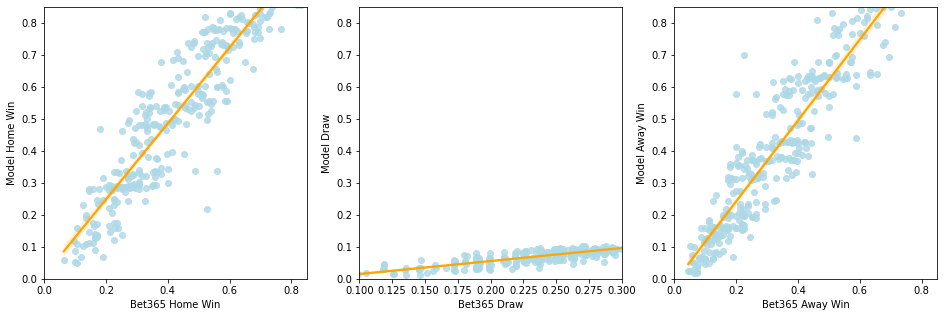

In [15]:
## Plot of Model Probabilities vs Bet365 Probabilities
plt.figure(figsize=(16, 5))

# Plot of Home Win Probabilities
plt.subplot(1, 3, 1)
sns.regplot(x = "BookiesWin", y = "HomeWin", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Home Win')
plt.ylabel('Model Home Win')
plt.xlim(0, 0.85)
plt.ylim(0, 0.85)

# Plot of Draw Probabilities
plt.subplot(1, 3, 2)
sns.regplot(x = "BookiesDraw", y = "Draw", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Draw')
plt.ylabel('Model Draw')
plt.xlim(0.1, 0.3)
plt.ylim(0, 0.85)

# Plot of Away Win Probabilities
plt.subplot(1, 3, 3)
sns.regplot(x = "BookiesLoss", y = "HomeLoss", data = data_betting, 
            scatter_kws = {"color": "lightblue"}, 
            line_kws = {"color": "orange"})
plt.xlabel('Bet365 Away Win')
plt.ylabel('Model Away Win')
plt.xlim(0, 0.85)
plt.ylim(0, 0.85)

plt.show()

<font face="Times New Roman"><h3>6.3 Ranked probability scores</h3>
The Ranked Probability Score (RPS) is a measure of how good forecasts are in matching observed outcomes. Where: RPS = 0 the forecast is wholly accurate; RPS = 1 the forecast is wholly inaccurate.
</font>

In [16]:
## RPS Comaprison
predictions_model = data_betting[['HomeWin', 'Draw', 'HomeLoss']]
predictions_model.columns = ['H', 'D', 'A']
predictions_bookies = data_betting[['BookiesWin', 'BookiesDraw', 'BookiesLoss']]
predictions_bookies.columns = ['H', 'D', 'A']
observed = pd.get_dummies(data_betting['FTR']).reindex(
    columns=predictions_model.columns, fill_value=0)

RPS_model = rps(predictions_model, observed).round(5)
RPS_bookies= rps(predictions_bookies, observed).round(5)

# Display of RPS score and their Difference
print("Ranked Probability Score of our model",round(np.mean(RPS_model),4))
print("Ranked Probability Score of Bookies model",round(np.mean(RPS_bookies),4))
print("Ranked Probability Score difference",round((np.mean(RPS_model) - np.mean(RPS_bookies)),4))

Ranked Probability Score of our model 0.2173
Ranked Probability Score of Bookies model 0.1992
Ranked Probability Score difference 0.0182


<font face="Times New Roman"><h3>6.4 Confusion Matrix</h3>
A confusion matrix is a table that is used to define the performance of a classification algorithm. A confusion matrix visualizes and summarizes the performance of a classification algorithm.
</font>

<AxesSubplot:title={'center':'True Vs Bookies Model'}>

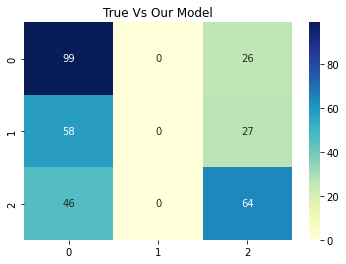

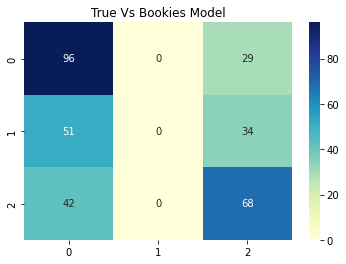

In [17]:
## Confusion Matrix
y_model = np.argmax(np.array(predictions_model), axis = 1)
y_bookies = np.argmax(np.array(predictions_bookies), axis = 1)
y_true = np.argmax(np.array(observed), axis = 1)

# Obtaining the Confusion Matrix
cm1 = confusion_matrix(y_true, y_model)
cm2 = confusion_matrix(y_true, y_bookies)
plt.figure()
plt.title('True Vs Our Model')
sns.heatmap(cm1, annot=True, cmap='YlGnBu')
plt.figure()
plt.title('True Vs Bookies Model')
sns.heatmap(cm2, annot=True, cmap='YlGnBu')

<font face="Times New Roman"><h3>6.5 Precision, Recall and F1-Score Table</h3>
Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.<br>
F1-score is the harmonic mean of precision and recall. It combines precision and recall into a single number using the following formula: This formula can also be equivalently written as, Notice that F1-score takes both precision and recall into account, which also means it accounts for both False Positives and False Negatives.
</font>

In [18]:
# Precision, Recall and F1-score for Model and Bet365
from sklearn import metrics
print('\033[1m'+'True Vs Our Model\n'+'\033[0m')
print(metrics.classification_report(y_true, y_model, target_names = ['H','D','A']))
print('\033[1m'+'True Vs Bookies Model\n'+'\033[0m')
print(metrics.classification_report(y_true, y_bookies, target_names = ['H','D','A']))

True Vs Our Model

              precision    recall  f1-score   support

           H       0.49      0.79      0.60       125
           D       0.00      0.00      0.00        85
           A       0.55      0.58      0.56       110

    accuracy                           0.51       320
   macro avg       0.34      0.46      0.39       320
weighted avg       0.38      0.51      0.43       320

True Vs Bookies Model

              precision    recall  f1-score   support

           H       0.51      0.77      0.61       125
           D       0.00      0.00      0.00        85
           A       0.52      0.62      0.56       110

    accuracy                           0.51       320
   macro avg       0.34      0.46      0.39       320
weighted avg       0.38      0.51      0.43       320



C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DELL\anaconda3\envs\tf\li